In [1]:
import pickle
import shutil

import numpy as np
import matplotlib.pyplot as plt

# from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

import os
import glob

from emcee.autocorr import integrated_time
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

%load_ext autoreload
%autoreload 2

## Load pulsars and PTA object

In [2]:
# load Enterprise pulsar objects
with open('ent_data_simulation/data/enterprise_pulsars.pkl', 'rb') as f:
    psrs = pickle.load(f)

# load Enterprise PTA object
with open('ent_data_simulation/data/pta.pkl', 'rb') as f:
    pta = pickle.load(f)

for psr in psrs:
    print(psr.name)

J0406+3039
J1745+1017
J1832-0836
J1909-3744
J1751-2857


In [3]:
# load injected parameters
data_dict = np.load('ent_data_simulation/data/data_dict.npz', allow_pickle=True)
x_inj_dict = data_dict['x_inj'].item()

In [4]:
print(pta.summary())

enterprise v3.3.3,  Python v3.10.14

Signal Name                              Signal Class                   no. Parameters      
J0406+3039_linear_timing_model_svd       TimingModel                    0                   

params:
__________________________________________________________________________________________
J0406+3039_measurement_noise             MeasurementNoise               0                   

params:
__________________________________________________________________________________________
J0406+3039_red_noise                     FourierBasisGP                 2                   

params:
J0406+3039_red_noise_log10_A:Uniform(pmin=-30.0, pmax=-10.0)                              
J0406+3039_red_noise_gamma:Uniform(pmin=0.1, pmax=20.0)                                   
__________________________________________________________________________________________
J0406+3039_cw                            CWSignal                       10                  

params:
cw_cost

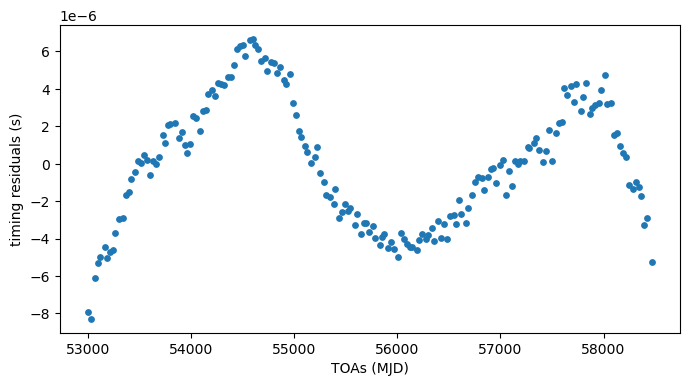

In [5]:
# plot timing residuals
psr_ndx = 0
plt.figure(figsize=(8, 4))
plt.scatter(psrs[psr_ndx].toas / 86400., psrs[psr_ndx].residuals, s=15)
plt.xlabel('TOAs (MJD)')
plt.ylabel('timing residuals (s)')
plt.show()

## test Enterprise likelihood

In [6]:
def get_dict(params):
    return {param_name: param for param_name, param in zip(pta.param_names, params)}

In [7]:
# likelihood function
def get_lnlike(params):
    return pta.get_lnlikelihood(get_dict(params))

# prior function
def get_lnprior(params):
    return pta.get_lnprior(get_dict(params))

# posterior
def get_lnpost(params):
    return get_lnprior(params) + get_lnlike(params)

In [8]:
x_test = np.array([param.sample() for param in pta.params])
print(get_lnpost(x_test))

-49839.14141640424


In [9]:
%timeit get_lnpost(x_test)

729 μs ± 2.88 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
# store injected parameters in array
x_inj = []
for param_name in pta.param_names:
    print(f'{param_name} = {x_inj_dict[param_name]}')
    if param_name[-6:] == 'p_dist':  # pulsar distances are normalized
        x_inj.append(0.)
    else:
        x_inj.append(x_inj_dict[param_name])
x_inj = np.array(x_inj)

J0406+3039_cw_p_dist = 1.0
J0406+3039_cw_p_phase = 0.21070298773999596
J0406+3039_red_noise_gamma = 4.6
J0406+3039_red_noise_log10_A = -13.5
J1745+1017_cw_p_dist = 1.0
J1745+1017_cw_p_phase = 2.068401028995659
J1745+1017_red_noise_gamma = 3.6
J1745+1017_red_noise_log10_A = -13.7
J1751-2857_cw_p_dist = 1.0
J1751-2857_cw_p_phase = 2.3865553837754803
J1751-2857_red_noise_gamma = 4.0
J1751-2857_red_noise_log10_A = -14.0
J1832-0836_cw_p_dist = 1.0
J1832-0836_cw_p_phase = 2.5217844012682527
J1832-0836_red_noise_gamma = 4.5
J1832-0836_red_noise_log10_A = -14.1
J1909-3744_cw_p_dist = 1.26
J1909-3744_cw_p_phase = 1.624565111709483
J1909-3744_red_noise_gamma = 4.2
J1909-3744_red_noise_log10_A = -13.8
cw_cosinc = 0.9510565162951535
cw_costheta = 6.123233995736766e-17
cw_log10_Mc = 8.9
cw_log10_dL = 0.0
cw_log10_fgw = -8.397940008672037
cw_phase0 = 0.7853981633974483
cw_phi = 4.39822971502571
cw_psi = 1.0471975511965976


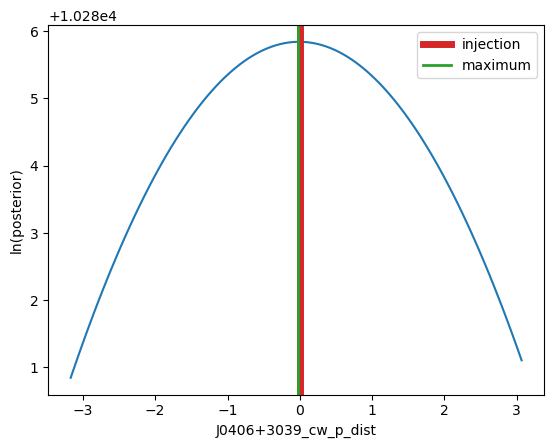

In [11]:
# plot cross-sections of posterior
param_ndx = 0
num_evals = 100
# get "minimum" and "maximum" of parameter values
param_samples = np.array([pta.params[param_ndx].sample() for _ in range(1000)])
param_vals = np.linspace(np.min(param_samples), np.max(param_samples), num_evals)
x_vals = np.tile(x_inj, (num_evals, 1))
x_vals[:, param_ndx] = param_vals
lnposts = np.array([get_lnpost(x) for x in x_vals])
plt.plot(param_vals, lnposts)
plt.axvline(x_inj[param_ndx], color='C3', label='injection', lw=5)
plt.axvline(param_vals[np.argmax(lnposts)], color='C2', label='maximum', lw=2)
plt.legend()
plt.xlabel(pta.param_names[param_ndx])
plt.ylabel('ln(posterior)')
plt.show()

## load MCMC samples

In [13]:
folder = 'enterprise_chains'

# Find all files matching chain_*.txt
files = glob.glob(os.path.join(folder, "chain_*.txt"))

# Extract temperatures from filenames
def get_temp(fname):
    base = os.path.basename(fname)
    temp_str = base.replace("chain_", "").replace(".txt", "")
    return float(temp_str)

# load chains
files_sorted = sorted(files, key=get_temp)
chains = [np.loadtxt(f) for f in files_sorted]
ladder = [get_temp(f) for f in files_sorted]

# make pandas data frame for each chain
dfs = []
lnlikes = []
for chain, temp in zip(chains, ladder):
    dfs.append(pd.DataFrame(chain[:, :len(pta.param_names)], columns=pta.param_names))
    lnlikes.append(chain[:, -3])

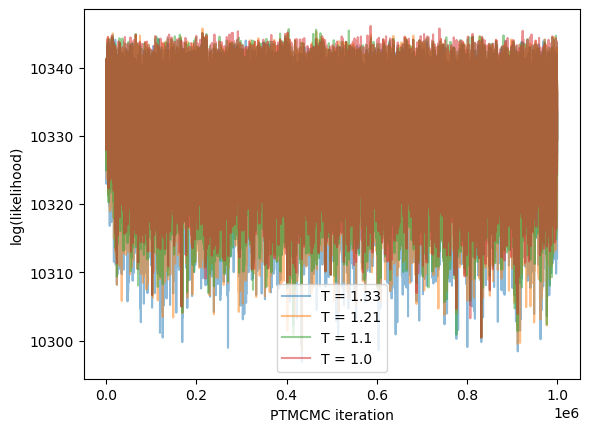

In [14]:
_ = [plt.plot(lnlike, color=f'C{i}', label=f'T = {temp}', alpha=0.5)
     for i, (lnlike, temp) in enumerate(zip(lnlikes[::-1], ladder[::-1]))]
plt.xlabel('PTMCMC iteration')
plt.ylabel('log(likelihood)')
plt.legend()
plt.show()

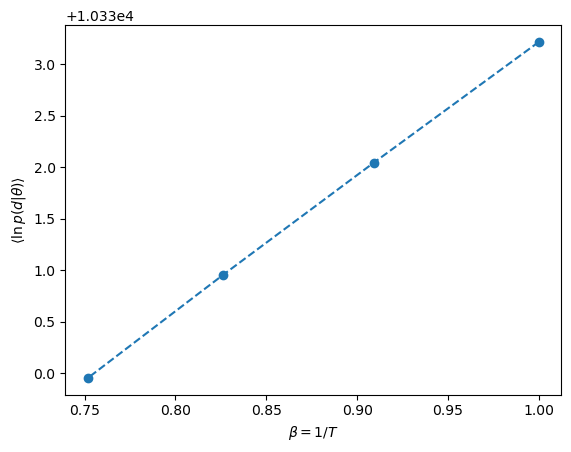

In [15]:
# illustrate thermodynamic integration
burnin = 100_000
betas = 1. / np.array(ladder)
plt.plot(betas, [np.mean(lnlike[burnin:], axis=0)
                 for lnlike in lnlikes], ls='--', marker='o')
plt.xlabel(r'$\beta = 1 / T$')
plt.ylabel(r'$\langle \ln p(d | \theta) \rangle$')
plt.show()

Parameter cw_cosinc in chain T = 1.0 is not constrained
Parameter cw_cosinc in chain T = 1.1 is not constrained
Parameter cw_cosinc in chain T = 1.21 is not constrained
Parameter cw_cosinc in chain T = 1.33 is not constrained
Parameter cw_log10_Mc in chain T = 1.0 is not constrained
Parameter cw_log10_Mc in chain T = 1.1 is not constrained
Parameter cw_log10_Mc in chain T = 1.21 is not constrained
Parameter cw_log10_Mc in chain T = 1.33 is not constrained
Parameter cw_log10_dL in chain T = 1.0 is not constrained
Parameter cw_log10_dL in chain T = 1.21 is not constrained
Parameter cw_log10_dL in chain T = 1.33 is not constrained


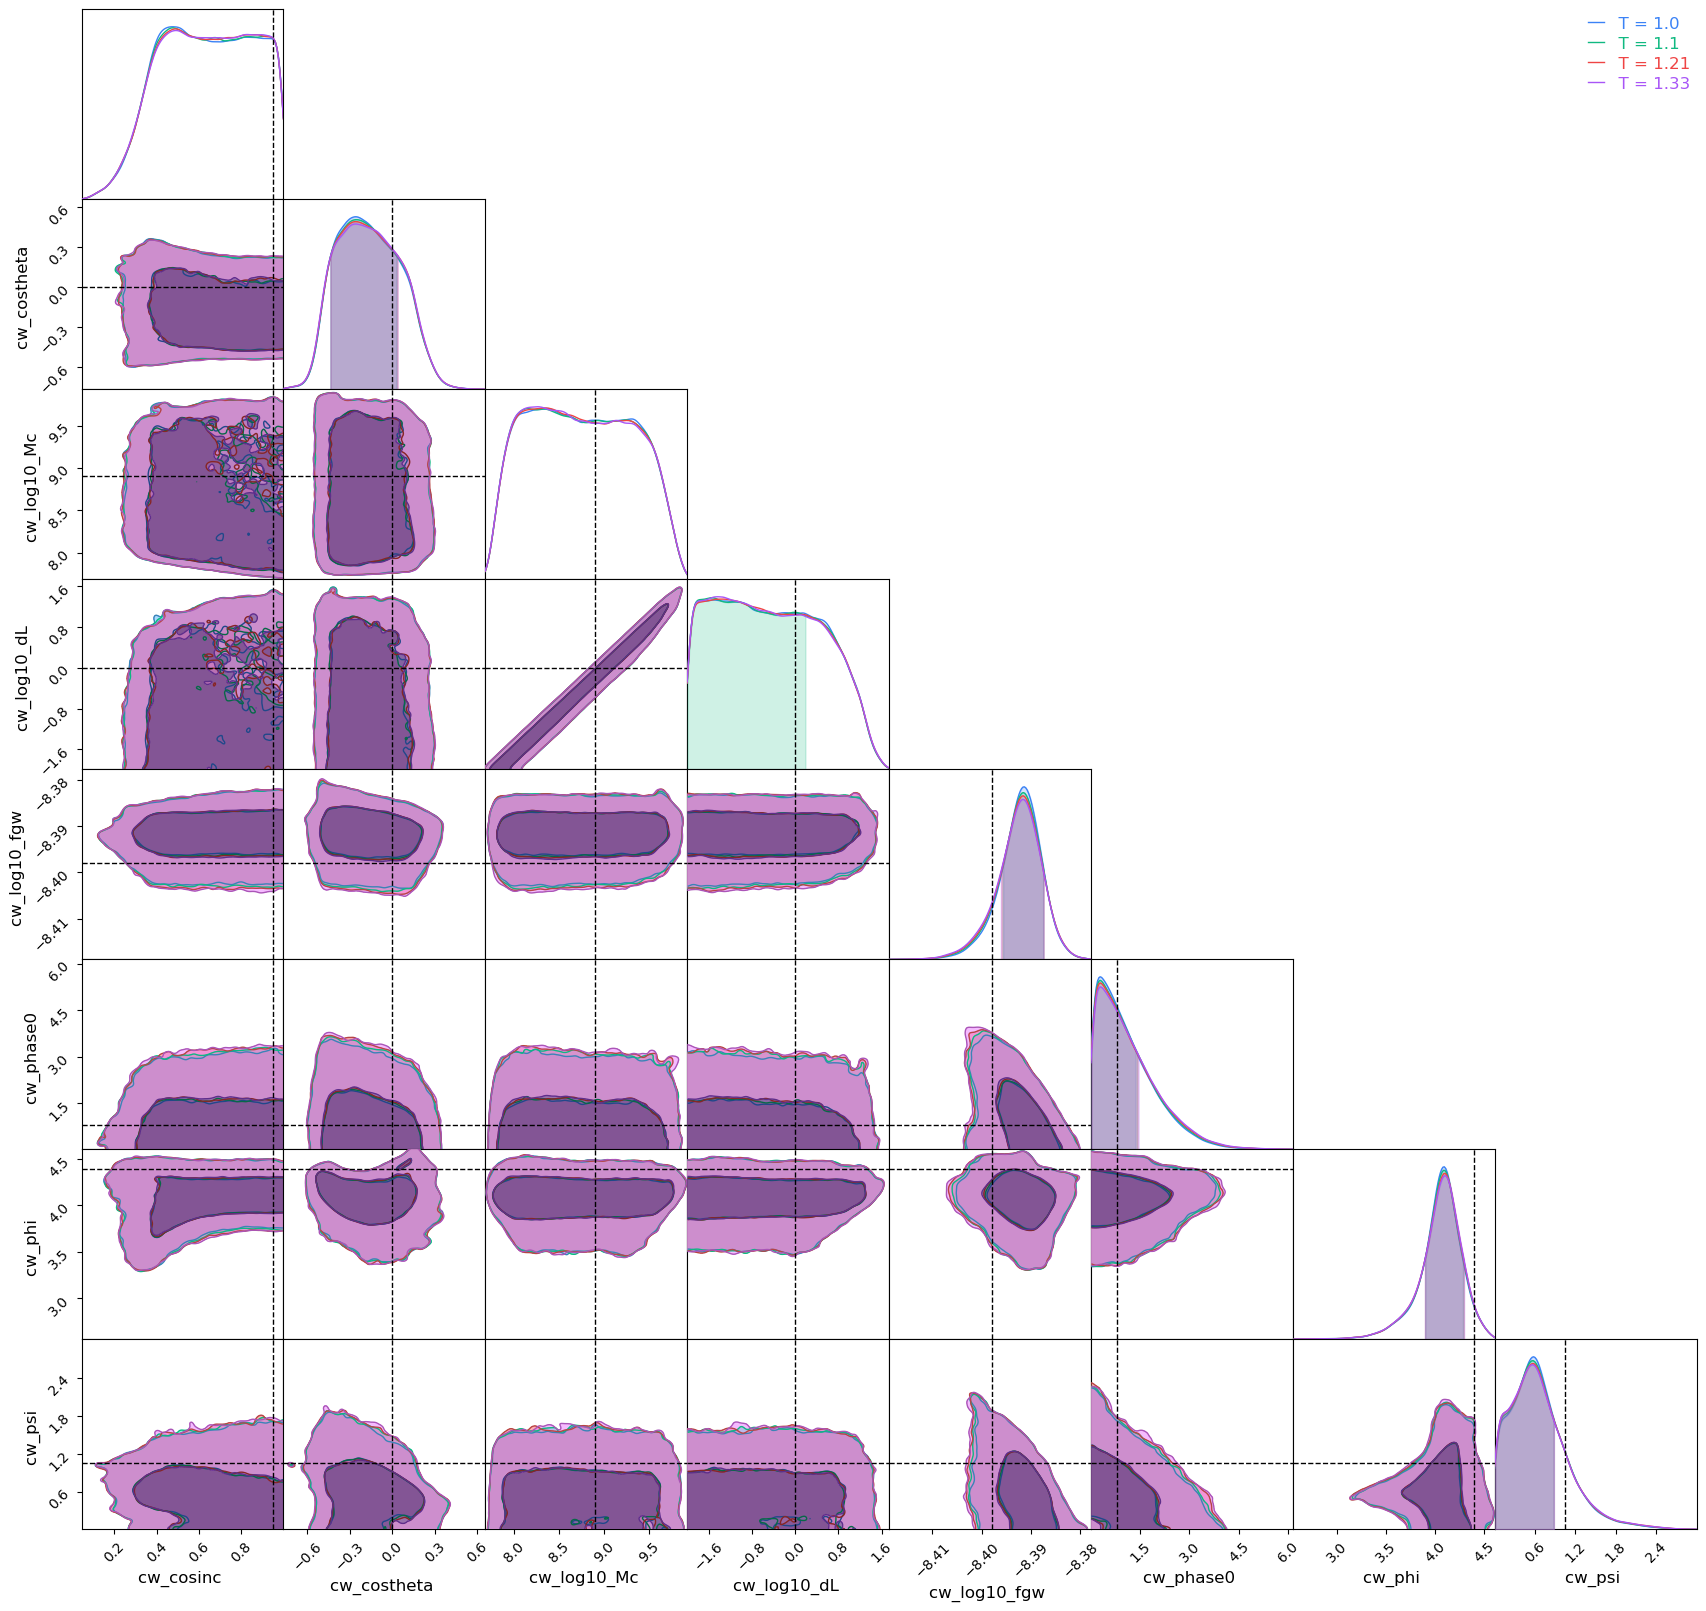

In [16]:
param_ndxs = np.r_[-8:0]
c = ChainConsumer()
for df, temp in zip(dfs, ladder):
    c.add_chain(Chain(samples=df.iloc[burnin:, param_ndxs], name=f'T = {temp}'))
c.add_truth(Truth(location=x_inj_dict))
fig = c.plotter.plot()

In [17]:
# save data frame for T = 1 chain
dfs[0].iloc[burnin:].to_pickle("ent_df.pkl.gz", compression="gzip")